# Multiclass Perceptron
In the previous discussion we've gone over a perceptron with only 2 classes. In this notebook we'll show how it can work on multiple classes, following the slides from the lecture.

In [1]:
# Import all required libraries
from __future__ import division # For python 2.*

import numpy as np
import matplotlib.pyplot as plt
import mltools as ml

np.random.seed(0)
%matplotlib inline

# Data Sampling

In [2]:
x_0 = np.random.normal(loc=[-4, 2], scale=0.5, size=(100, 2))
x_1 = np.random.normal(loc=[-4, -3], scale=0.5, size=(100, 2))
x_2 = np.random.normal(loc=[4, 1], scale=0.5, size=(100, 2))
x_3 = np.random.normal(loc=[5, -2], scale=0.5, size=(100, 2))

X = np.vstack([x_0, x_1, x_2, x_3])
Y = np.ones(X.shape[0], dtype=np.intc)
Y[:100] = 0
Y[100:200] = 1
Y[200:300] = 2
Y[300:] = 3

C:\Users\dheer\Documents\workspace\CS178-Discussions\week4\mltools\plot.py:42: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  hld = axis.ishold();
C:\Users\dheer\Documents\workspace\CS178-Discussions\week4\mltools\plot.py:43: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  axis.hold(True);
c:\users\dheer\python3.6\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
c:\users\dheer\python3.6\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will 

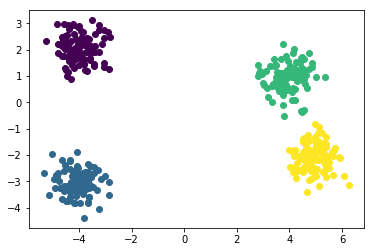

In [3]:
ml.plotClassify2D(None, X, Y)

In [4]:
classes = np.unique(Y)
print(classes)

[0 1 2 3]


## Multiclass Preceptron Training Algorithm

We use one-vs-all approach and learn paramaters for each class

<img src="images/1vsall.png">

One of the main differences is that now there is a $\theta_c$ for each class. So in the algorithm above $\theta$ is basically size $\#Classes \times \#Features$. 

To find the class, instead of using the sign threshold on the response, we are looking for the class that maximizes the response.

2-class decision rule sign($X\theta^T$) ; target $\in$ {-1, 1}<br>
k-class decision rule $\underset{c}{\arg\max} (X\theta^T)$ ; target $\in$ [1,c]

So let's adapt the code from the previous discussion to do this.

Let's add the const to the X and create the theta matrix.

In [5]:
# Like previous discussion
def add_const(X):
    return np.hstack([np.ones([X.shape[0], 1]), X])

In [6]:
Xconst = add_const(X)
theta = np.random.randn(classes.shape[0], Xconst.shape[1]) # Adding 1 for theta corresponding to bias term
print(theta.shape)

(4, 3)


In [7]:
# The response is also the same, only we transpose the theta.
def resp(x, theta):
    return np.dot(x, theta.T)

For the predict we need to find the class that maximizes the response. We can do this with np.argmax().

In [8]:
def predict(x, theta): 
    r = resp(x, theta)
    return np.argmax(np.atleast_2d(r), axis=1)

# Error stays the same
def pred_err(X, Y, theta):
    """Predicts that class for X and returns the error rate. """
    Yhat = predict(X, theta)
    return np.mean(Yhat != Y)

In [9]:
x_j, y_j = Xconst[5], Y[5]
pred_vals = predict(x_j, theta)
print('Predicted class %d, True class is %d' % (pred_vals, y_j))

Predicted class 3, True class is 0


## Learning Update

In [10]:
a = 0.1
y_j_hat = predict(x_j, theta)

theta[y_j_hat] -= a * x_j
theta[y_j] += a * x_j

#Lower score for wrong prediction but increase for correct prediction

## Train method
Using everything we coded so far, let's code the training method.

In [11]:
def train(X, Y, a=0.01, stop_tol=1e-8, max_iter=50):
    Xconst = add_const(X)
    m, n = Xconst.shape
    c = np.unique(Y).shape[0]
    
    # Initializing theta
    theta = np.random.rand(c, n)
    
    # The update loop
    J_err = []
    for i in xrange(1, max_iter + 1):
        for j in range(m):
            x_j, y_j = Xconst[j], Y[j]
            y_j_hat = predict(x_j, theta)
            theta[y_j_hat] -= a * x_j
            theta[y_j] += a * x_j
        
        curr_err = pred_err(Xconst, Y, theta)
        J_err.append(curr_err)
        
        print('Error %.3f at iteration %d' % (J_err[-1], i))
    
    return theta, J_err

## Multiclass Pereptron Object
Let us put this all in a class MultiPerceptron. 

In [12]:
from mltools.base import classifier
class MultiClassPerceptron(classifier):
    def __init__(self, theta=None):
        self.theta = theta
        
    def add_const(self, X):
        return np.hstack([np.ones([X.shape[0], 1]), X])

    def resp(self, x):
        return np.dot(x, self.theta.T)    
    
    def predict(self, X):
        """Retruns class prediction for either single point or multiple points. """
        Xconst = np.atleast_2d(X)
        
        # Making sure it has the const, if not adding it.
        if Xconst.shape[1] == self.theta.shape[1] - 1:
            Xconst = self.add_const(Xconst)
        
        r = self.resp(Xconst)
        return np.argmax(np.atleast_2d(r), axis=1)
  
    # Notice that we don't need the sign function (from Perceptron class) any longer
#     def sign(self, vals):
#         """A sign version with breaking 0's as +1. """
#         return np.sign(vals + 1e-200)
    
    def pred_err(self, X, Y):
        Yhat = self.predict(X)
        return np.mean(Yhat != Y)

    def train(self, X, Y, a=0.01, stop_tol=1e-8, max_iter=50):
        # Start by adding a const
        Xconst = self.add_const(X)

        m, n = Xconst.shape
        c = np.unique(Y).shape[0]
        self.classes = np.unique(Y)
        
        # Making sure Theta is inititialized.
        if self.theta is None:
            self.theta = np.random.randn(c, n)

        # The update loop
        J_err = []
        for i in range(1, max_iter + 1):
            for j in np.random.permutation(m):
                x_j, y_j = Xconst[j], Y[j]
                y_j_hat = self.predict(x_j)

                self.theta[y_j_hat[0]] -= a * x_j
                self.theta[y_j] += a * x_j
                
            curr_err = self.pred_err(Xconst, Y)
            J_err.append(curr_err)

        return J_err    

Let's train and plot :)

C:\Users\dheer\Documents\workspace\CS178-Discussions\week4\mltools\plot.py:42: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  hld = axis.ishold();
C:\Users\dheer\Documents\workspace\CS178-Discussions\week4\mltools\plot.py:43: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  axis.hold(True);
c:\users\dheer\python3.6\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
c:\users\dheer\python3.6\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will 

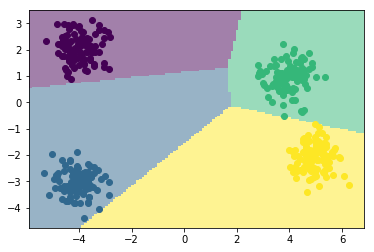

In [13]:
model = MultiClassPerceptron()
j_err = model.train(X, Y, a=.02, max_iter=50)
ml.plotClassify2D(model, X, Y)

## Bonus question
In the plot below we have two classes. Let's assume that I want to have multiclass perceptron with 2 classes, what would theta have to be to separate them correctly?

C:\Users\dheer\Documents\workspace\CS178-Discussions\week4\mltools\plot.py:42: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  hld = axis.ishold();


(200, 2)


C:\Users\dheer\Documents\workspace\CS178-Discussions\week4\mltools\plot.py:43: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  axis.hold(True);
c:\users\dheer\python3.6\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
c:\users\dheer\python3.6\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
C:\Users\dheer\Documents\workspace\CS178-Discussions\week4\mltools\plot.py:64: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  a

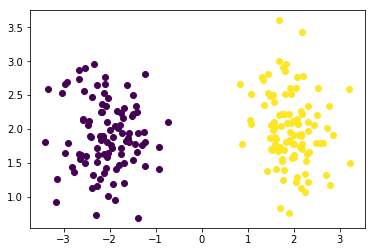

In [14]:
x_0 = np.random.normal(loc=[-2, 2], scale=0.5, size=(100, 2))
x_1 = np.random.normal(loc=[2, 2], scale=0.5, size=(100, 2))

X = np.vstack([x_0, x_1])
print(X.shape)
Y = np.ones(X.shape[0], dtype=np.intc)
Y[:100] = 0
Y[100:200] = 1

ml.plotClassify2D(None, X, Y)

In [ ]:
theta = ???  # Fill in the code and run
model = MultiClassPerceptron(theta)
model.train(X, Y, a=.02, max_iter=50)
ml.plotClassify2D(model, X, Y)